In [32]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-

#__modification time__ = 2025-04-16
#__author__ = Kshitij Kar, GFZ Helmholtz Centre for Geosciences
#__find me__ = kshitkar@gfz.de

# Setup
## Importing modules

In [33]:
import os
import sys
import yaml

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

from datetime import datetime

from obspy import read, Trace, Stream
from obspy.core import UTCDateTime

import torch
from sklearn.metrics import confusion_matrix

# <editor-fold desc="add the sys.path to search for custom modules">
from pathlib import Path
# current_dir = Path(__file__).resolve().parent # for .py project
current_dir = current_dir = Path().resolve() # for .ipynb project
# using ".parent" on a "pathlib.Path" object moves one level up the directory hierarchy
project_root = current_dir.parent
import sys
sys.path.append(str(project_root))
# </editor-fold>


# import the custom functions
from functions.public.load_data import select_features
from functions.public.dataset_to_dataloader import *
from functions.model.lstm_model import Ensemble_Trained_LSTM_Classifier
from functions.model.tree_ensemble_model import Ensemble_Trained_Tree_Classifier
from functions.seismic_data_processing_obspy.seismic_data_processing import load_seismic_signal

# print the working path
print(f"current_dir: {current_dir},\n"
      f"project_root: {project_root}")

current_dir: /Users/qizhou/#python/#GitHub_saved/Diversity-of-Debris-Flow-Footprints/docs,
project_root: /Users/qizhou/#python/#GitHub_saved/Diversity-of-Debris-Flow-Footprints


## Setting directories

In [34]:
# Set the dir. Nothing needs to be changed here, this helps the following setup sections.
inference_output = f"{current_dir}/inference_output"
os.makedirs(inference_output, exist_ok=True)

# Load the config yaml file with details for LSTM model inference and feature explainations
with open(f"{project_root}/config/config_inference.yaml", "r") as f:
    inference_config = yaml.safe_load(f)


## Define parameters

In [35]:
# Define model version (v1), model type (LSTM, XGB, RF), and feature group (A, B, C)
model_version = "v1-model" # We plan to release the new version of the trained model. If you would like early access, feel free to contact us via email.

model_type = "XGBoost" # ["LSTM", "XGBoost", "Random_Forest"]
feature_type = "C" # ["A", "B", "C"]

model_dir = f"{project_root}/trained_model/{model_version}/{model_type}"
seismic_feature_dir = f"{project_root}/data/seismic_features" # f"{current_dir}/feature_output"

print(f"Trained Model directory: {model_dir} \n"
      f"Seismic directory: {seismic_feature_dir}")



# Specify the details listed below. This is an example for the Illgraben catchment where features are already calculated.
continent = "European" # For the directory structure on GLIC, this is either "European" or "Asian" etc
catchment_name = 'Illgraben' # Catchment name as used on GLIC
station = "ILL12" # Station name as used on GLIC (Possible bug, since ILL12 station has ILL02 as model name, I replace 1 by 0 in the functions below internally)
# If another station name is used, and the name contains a 1, this might throw an error of file not found in section "Load and run the model"
network = "9S"
component = "EHZ"
year = 2020
julday = 243 # 2020-08-30

# Verify that the directory printed above exists and contains all the trained models

Trained Model directory: /Users/qizhou/#python/#GitHub_saved/Diversity-of-Debris-Flow-Footprints/trained_model/v1-model/XGBoost 
Seismic directory: /Users/qizhou/#python/#GitHub_saved/Diversity-of-Debris-Flow-Footprints/data/seismic_features


# Perform Inference on Seismic Data
## Load the data and calculate the features

In [36]:
if catchment_name == "Illgraben":
    print("Features already calculated, skipping feature calculation")
    # load data_array as [time_stamps, features, target]
    feature_names, data_array = select_features(catchment_name=catchment_name,
                                                seismic_network=network,
                                                input_year=year,
                                                input_station=station,
                                                input_component=component,
                                                feature_type=feature_type,
                                                with_label=False, # by default the labels are not being loaded
                                                normalize=True)
    id1 = np.where(data_array[:, 0] == UTCDateTime(year=year, julday=julday).timestamp)[0][0]
    id2 = np.where(data_array[:, 0] == UTCDateTime(year=year, julday=julday+1).timestamp)[0][0]
    data_array = data_array[id1:id2, :]
else:
    print("Please Calculate Seismic Features")
    #TODO: Add feature calculation code here
    pass
print(f"Loaded data shape : {data_array.shape}")
print(f"Feature Count : {len(feature_names)}\nFeature names : {list(feature_names)}")

if model_type == "LSTM":
    print(inference_config[f'feature_type_{feature_type}'])
    model_config = inference_config[f'LSTM_{feature_type}']
    print(model_config)

    batch_size = model_config['batch_size']
    seq_len = model_config['seq_length']

    sequences = data_to_seq(data_array, seq_length=seq_len)
    dataset = seq_to_dataset(sequences=sequences, data_type="feature")
    dataloader = dataset_to_dataloader(dataset=dataset,
                                    batch_size=batch_size,
                                    training_or_testing="testing")
    dataLoader = dataloader.dataLoader()
else:
    dataloader = data_array

Features already calculated, skipping feature calculation
Loaded data shape : (1440, 82)
Feature Count : 80
Feature names : ['digit1', 'digit2', 'digit3', 'digit4', 'digit5', 'digit6', 'digit7', 'digit8', 'digit9', 'goodness', 'alpha', 'RappMaxMean', 'RappMaxMedian', 'AsDec', 'KurtoSig', 'KurtoEnv', 'SkewnessSig', 'SkewnessEnv', 'CorPeakNumber', 'INT1', 'INT2', 'INT_RATIO', 'ES_0', 'ES_1', 'ES_2', 'ES_3', 'ES_4', 'KurtoF_0', 'KurtoF_1', 'KurtoF_2', 'KurtoF_3', 'KurtoF_4', 'DistDecAmpEnv', 'env_max_to_duration', 'RMS', 'IQR', 'MeanFFT', 'MaxFFT', 'FmaxFFT', 'FCentroid', 'Fquart1', 'Fquart3', 'MedianFFT', 'VarFFT', 'NpeakFFT', 'MeanPeaksFFT', 'E1FFT', 'E2FFT', 'E3FFT', 'E4FFT', 'gamma1', 'gamma2', 'gammas', 'SpecKurtoMaxEnv', 'SpecKurtoMedianEnv', 'RatioEnvSpecMaxMean', 'RatioEnvSpecMaxMedian', 'DistMaxMean', 'DistMaxMedian', 'NbrPeakMax', 'NbrPeakMean', 'NbrPeakMedian', 'RatioNbrPeakMaxMean', 'RatioNbrPeakMaxMedian', 'NbrPeakFreqCenter', 'NbrPeakFreqMax', 'RatioNbrFreqPeaks', 'DistQ2Q1'

## Load and run the model

In [37]:
if model_type == "LSTM":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    ensemble_pre_trained_LSTM = Ensemble_Trained_LSTM_Classifier(f"{model_type}_{feature_type}", model_version, device, model_dir=model_dir, station=station.replace("1","0"))
    models = ensemble_pre_trained_LSTM.ensemble_models(num_repeat=5, attention=False)
    print(models)
    tensor_temp = ensemble_pre_trained_LSTM.predictor_from_dataLoader(dataLoader, models)
    np.save(f"{inference_output}/{model_type}_{feature_type}.npy", tensor_temp)
    print(f"Inference saved to {inference_output}")
else:
    ensemble_pre_trained_tree = Ensemble_Trained_Tree_Classifier(f"{model_type}_{feature_type}", model_version, model_dir=model_dir, station=station.replace("1","0"))
    models = ensemble_pre_trained_tree.ensemble_models(num_repeat=5)
    # print(models)
    tensor_temp = ensemble_pre_trained_tree.predictor_from_dataloader(dataloader, models)
    np.save(f"{inference_output}/{model_type}_{feature_type}.npy", tensor_temp)
    print(f"Inference saved to {inference_output}")

Loaded pre-trained model: /Users/qizhou/#python/#GitHub_saved/Diversity-of-Debris-Flow-Footprints/trained_model/v1-model/XGBoost/ILL02_XGBoost_C_repeat1.pkl
Loaded pre-trained model: /Users/qizhou/#python/#GitHub_saved/Diversity-of-Debris-Flow-Footprints/trained_model/v1-model/XGBoost/ILL02_XGBoost_C_repeat2.pkl
Loaded pre-trained model: /Users/qizhou/#python/#GitHub_saved/Diversity-of-Debris-Flow-Footprints/trained_model/v1-model/XGBoost/ILL02_XGBoost_C_repeat3.pkl
Loaded pre-trained model: /Users/qizhou/#python/#GitHub_saved/Diversity-of-Debris-Flow-Footprints/trained_model/v1-model/XGBoost/ILL02_XGBoost_C_repeat4.pkl
Loaded pre-trained model: /Users/qizhou/#python/#GitHub_saved/Diversity-of-Debris-Flow-Footprints/trained_model/v1-model/XGBoost/ILL02_XGBoost_C_repeat5.pkl
Inference saved to /Users/qizhou/#python/#GitHub_saved/Diversity-of-Debris-Flow-Footprints/docs/inference_output


## Generate plots

In [43]:
def psd_plot(ax, ax_twin, st, data_start, data_end, time_window_start, pre_y_pro, ci_range, index=None):
    start = UTCDateTime(data_start).timestamp
    end = UTCDateTime(data_end).timestamp

    if end - start > 3600 * 6:
        x_interval = 2
    else:
        x_interval = 1

    st.trim(UTCDateTime(data_start), UTCDateTime(data_end))
    st.spectrogram(per_lap=0.5, wlen=60, log=False, dbscale=True, mult=True, title="", axes=ax, cmap='inferno')
    ax.images[0].set_clim(-180, -100)

    temp = f"{UTCDateTime(data_start).strftime('%Y-%m-%d')}, Day {UTCDateTime(data_start).julday}"
    ax.set_title(label=f" {temp}", weight="bold", color="black", fontsize=7, zorder=7)

    ax.set_ylim(1, 50)
    ax.set_yticks([1, 10, 20, 30, 40, 50], [1, 10, 20, 30, 40, 50])

    ax.xaxis.set_major_locator(ticker.MultipleLocator(60 * 60 * 2))  # unit is saecond

    x_location = np.arange(start, end + 1, 3600 * x_interval)
    x_ticks = []
    for j, k in enumerate(x_location):
        if j == 0:
            fmt = "%H:%M"
        else:
            fmt = "%H:%M"
        x_ticks.append(datetime.utcfromtimestamp(int(k)).strftime(fmt))

    ax.set_xticks(x_location-start, x_ticks)


    id1 = np.where(np.abs(time_window_start - start) ==
                   np.min(np.abs(time_window_start - start)))[0][0]
    id2 = np.where(np.abs(time_window_start - end) ==
                   np.min(np.abs(time_window_start - end)))[0][0]

    pro = pre_y_pro[id1:id2]
    ci_range_95 = ci_range[id1:id2]
    ci_lower = pro-ci_range_95
    ci_lower[ci_lower<0] = 0

    ci_upper = pro+ci_range_95
    ci_upper[ci_upper > 1] = 1

    x = np.arange(pro.size) * 60

    ax_twin.plot(x, pro, color="white", lw=1, zorder=2)
    ax_twin.fill_between(x, ci_lower, ci_upper, color="white", alpha=0.5, zorder=2)

    ax_twin.set_ylim(-0.05, 1.05)
    ax_twin.set_yticks([0, 0.25, 0.50, 0.75, 1], [0, 0.25, 0.50, 0.75, 1])
    ax_twin.grid(False)

In [39]:
###
# Here we load the data, it can be from wherever you want
# Over here, input directory is the directory where the mseed files and sensor response are stored (currently ./seismic_input/)
# This process may take a while depending on the size of the data due to remove sensor response
# The data is filtered to 1-45 Hz and detrended
###
continent = "European" # For the directory structure on GLIC, this is either "European" or "Asian" etc
catchment_name = 'Illgraben' # Catchment name as used on GLIC
station = "ILL12" # Station name as used on GLIC (Possible bug, since ILL12 station has ILL02 as model name, I replace 1 by 0 in the functions below internally)
# If another station name is used, and the name contains a 1, this might throw an error of file not found in section "Load and run the model"
network = "9S"
component = "EHZ"
year = 2020
julday = 243 # 2020-08-30

t_s = (UTCDateTime(year=year, julday=julday)).strftime("%Y-%m-%dT%H:%M:%S")
t_e = (UTCDateTime(year=year, julday=julday+1)).strftime("%Y-%m-%dT%H:%M:%S")
f_min, f_max = 1, 45
# make sure you have the following file
# ./data/seismic_data/European/Illgraben/2020/ILL12/EHZ/9S.ILL12.EHZ.2020.243.mseed
# ./data/seismic_data/European/Illgraben/2020/ILL12/EHZ/9S.ILL12.EHZ.2020.244.mseed
st = load_seismic_signal(catchment_name, network, station, component,
                         t_s, t_e, f_min, f_max,
                         remove_sensor_response=True, raw_data=False)
arr = np.load(f"{inference_output}/{model_type}_{feature_type}.npy")

In [40]:
time_window_start = arr[:, 0] # the first column contains the start time of the intervals used to make predictions
obs_y_pro = arr[:, 1] # the second column contains the observed labels
pre_y_pro = arr[:, -2] # the third column contains the predicted probabilities
ci_range = arr[:, -1] # the last column contains the confidence intervals
pre_y_pro2 = pre_y_pro.copy()
pre_y_pro[pre_y_pro>0.5] = 1 # thresholding the predicted probabilities
pre_y_pro[pre_y_pro<=0.5] = 0 
cm = confusion_matrix(obs_y_pro, pre_y_pro) # making the confusion matrix, it wont be useful if the data is not labelled
print(cm)

[[1109  331]
 [   0    0]]


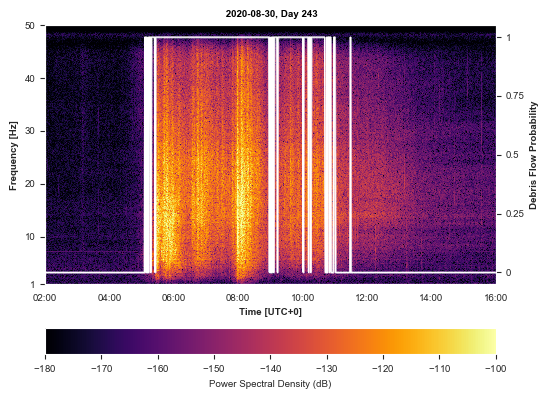

In [44]:
plt.rcParams.update( {'font.size':7,
                      'font.family': "Arial",
                      'axes.formatter.limits': (-3, 3),
                      'axes.formatter.use_mathtext': True} )

fig = plt.figure(figsize=(5.5, 4))
gs = gridspec.GridSpec(2, 1, height_ratios=[10, 1])
ax = plt.subplot(gs[0])


ax_twin = ax.twinx()
psd_plot(ax, ax_twin, st.copy(), "2020-08-30T02:00:00", "2020-08-30T16:00:00", time_window_start, pre_y_pro, ci_range, index=0)

cbar_ax = plt.subplot(gs[1])
cbar = fig.colorbar(ax.images[0], cax=cbar_ax, orientation="horizontal")
cbar.set_label("Power Spectral Density (dB)")

ax.set_ylabel('Frequency [Hz]', weight='bold')
ax_twin.set_ylabel("Debris Flow Probability", weight='bold')
ax.set_xlabel('Time [UTC+0]', weight='bold')
fig.tight_layout()
fig.savefig(f"{inference_output}/{catchment_name}_{station}_{model_type}_{feature_type}_psd_plot.png", dpi=600, bbox_inches='tight')
plt.show()
plt.close(fig=fig)